In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/resnet18_init/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:0'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 254.92it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 2347.59it/s]


absolute alignment indicates number: 167 label diff indicates number: 13 confidence diff indicates number: 15 high distance number: 75


In [2]:
X = ref_train_data
Y = tar_train_data

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from AlignVis.losses import KNNOverlapLoss, CKALoss, PredictionLoss, ConfidenceLoss

# Define a neural network architecture
class MyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the neural network
input_size = Y.shape[1]
hidden_size = 100
output_size = X.shape[1]
model = MyNet(input_size, hidden_size, output_size)



# Define the optimizer and the CKA loss
optimizer = torch.optim.Adam(model.parameters())
def loss_fn(X, Y):
    Y_pred = model(Y)
    m = len(X)
    loss1 = ((( X - Y_pred)**2).sum())/m
    ##### knn loss
    knn_overlap_loss = KNNOverlapLoss(k=10)
    ##### knn overleap different with target
    knn_loss = knn_overlap_loss(Y, Y_pred)

    #### CKA loss
    cka_loss_f = CKALoss(gamma=None, alpha=1e-3)
    cka_loss = cka_loss_f(X,Y_pred,Y)

    #      #### Prediction loss
    # pred_loss_fn = PredictionLoss(tar_model, ref_model, tar_provider, ref_provider, TAR_EPOCH, REF_EPOCH, DEVICE, 0.5)
    # pred_loss = pred_loss_fn(Y_pred, Y.detach().numpy())

    # loss = cka_loss(X, Y_pred) + knn_loss
    return loss1 + cka_loss + knn_loss ,cka_loss,knn_loss,loss1




In [4]:
import torch.utils.data as data_utils

# Define the dataset
dataset = data_utils.TensorDataset(torch.Tensor(X), torch.Tensor(Y))

# Define the DataLoader
batch_size = 200
dataloader = data_utils.DataLoader(dataset, batch_size=batch_size)

# Train the neural network with mini-batch processing
for epoch in range(200):
    
    
    for batch_X, batch_Y in dataloader:
        optimizer.zero_grad()
        loss, cka_loss, knn_loss,loss1 = loss_fn(batch_X, batch_Y)
        # print("epoch",epoch, "loss1",loss1,"cka_loss",cka_loss,"knn_loss",knn_loss,"pred_loss",pred_loss)
       
        loss.backward()
        optimizer.step()
    print("epoch",epoch,"loss1",loss1, "cka_loss",cka_loss,"knn_loss",knn_loss,"pred_loss")


epoch 0 loss1 tensor(122.0573, grad_fn=<DivBackward0>) cka_loss tensor(0.1141, grad_fn=<AddBackward0>) knn_loss tensor(0.1500, requires_grad=True) pred_loss
epoch 1 loss1 tensor(116.0263, grad_fn=<DivBackward0>) cka_loss tensor(0.1091, grad_fn=<AddBackward0>) knn_loss tensor(0.1680, requires_grad=True) pred_loss
epoch 2 loss1 tensor(111.2453, grad_fn=<DivBackward0>) cka_loss tensor(0.1063, grad_fn=<AddBackward0>) knn_loss tensor(0.1815, requires_grad=True) pred_loss
epoch 3 loss1 tensor(108.0104, grad_fn=<DivBackward0>) cka_loss tensor(0.1048, grad_fn=<AddBackward0>) knn_loss tensor(0.1895, requires_grad=True) pred_loss
epoch 4 loss1 tensor(105.6500, grad_fn=<DivBackward0>) cka_loss tensor(0.1038, grad_fn=<AddBackward0>) knn_loss tensor(0.1945, requires_grad=True) pred_loss
epoch 5 loss1 tensor(103.9482, grad_fn=<DivBackward0>) cka_loss tensor(0.1031, grad_fn=<AddBackward0>) knn_loss tensor(0.1980, requires_grad=True) pred_loss
epoch 6 loss1 tensor(102.6667, grad_fn=<DivBackward0>) cka

In [ ]:
# Train the neural network
for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_fn(X, Y)
    loss.backward()
    optimizer.step()

# Apply the trained model to new Y data
model.eval()
Y_new = torch.tensor(new_Y_data, dtype=torch.float32)
Y_new_highdim = model(Y_new)

In [14]:
# Apply the trained model to new Y data
model.eval()
Y_new = torch.tensor(Y, dtype=torch.float32)
Y_new_highdim = model(Y_new)

In [15]:
Y_new_highdim

torch.Size([50000, 512])

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8641.28it/s]


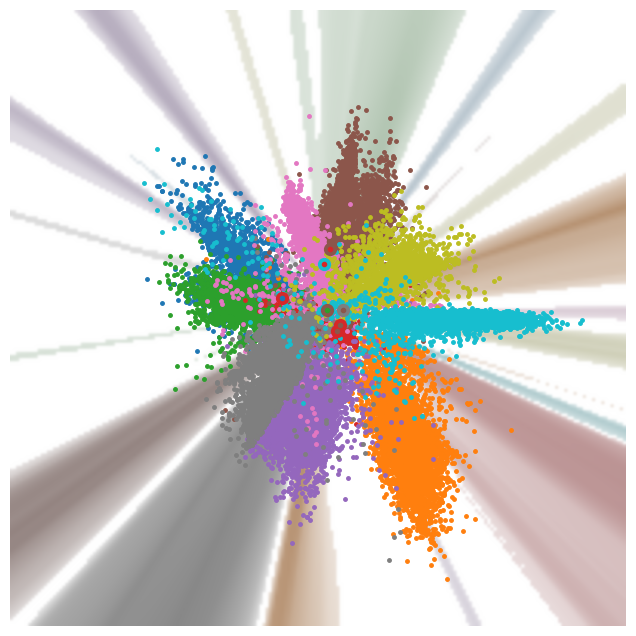

In [34]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVis.visualizerr import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I, Y_new_highdim.detach().numpy(), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8154.60it/s]


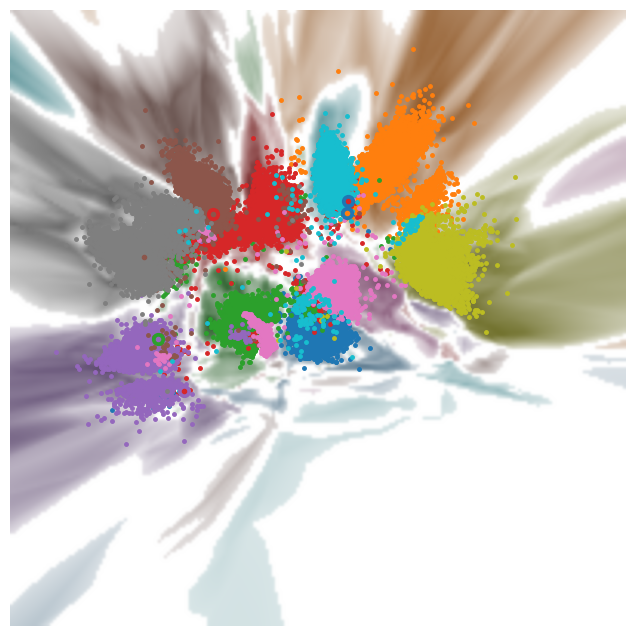

In [3]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from AlignVis.visualizerr import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I, ref_train_data, projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [12]:
def transform_Y_batch(Y_batch):
    model.eval()
    with torch.no_grad():
        Y_batch_highdim = model(Y_batch)
    return Y_batch_highdim
# Apply the trained model to each mini-batch of Y data
Y_highdim = torch.Tensor(Y)
for batch_Y in dataloader:
    batch_Y_highdim = transform_Y_batch(batch_Y)
    Y_highdim.append(batch_Y_highdim)

# Concatenate the high-dimensional Y data from each mini-batch
Y_highdim = torch.cat(Y_highdim, dim=0)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list